In [ ]:
# To store data
import pandas as pd

# To do linear algebra
import numpy as np
from numpy import pi

# To create plots
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt

# To create nicer plots
import seaborn as sns

# To create interactive plots
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# To get new datatypes and functions
from collections import Counter
from cycler import cycler

# To investigate distributions
from scipy.stats import norm, skew, probplot
from scipy.optimize import curve_fit

# To build models
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score




In [ ]:
train_df = pd.read_csv('/train.csv')
test_df = pd.read_csv('/test.csv')

# Combine boths dataframes
train_df['Data'] = 'Train'
test_df['Data'] = 'Test'
both_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
both_df['subject'] = '#' + both_df['subject'].astype(str)

# Create label
label = both_df.pop('Activity')

print('Shape Train:\t{}'.format(train_df.shape))
print('Shape Test:\t{}\n'.format(test_df.shape))

train_df.head()#first 5 rows

Shape Train:	(7352, 564)
Shape Test:	(2947, 564)



,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,Data
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,...,-0.936508,0.346989,-0.516080,-0.802760,-0.980135,-0.961309,-0.973653,-0.952264,-0.989498,-0.980135,-0.999240,-0.992656,-0.701291,-1.000000,-0.128989,0.586156,0.374605,-0.991990,-0.990697,-0.989941,-0.992448,-0.991048,-0.991990,-0.999937,-0.990458,-0.871306,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING,Train
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.999150,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-0.841270,0.532061,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993979,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING,Train
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.997130,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986028,-0.984274,-0.990979,-0.995703,-0.989255,-0.999854,-0.993238,-0.736521,-0.794872,-0.212728,-0.535352,

In [ ]:
# Group and count main names of columns
pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in both_df.columns]), orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False)

,count
fBodyAcc,79
fBodyGyro,79
fBodyAccJerk,79
tGravityAcc,40
tBodyAcc,40
tBodyGyroJerk,40
tBodyGyro,40
tBodyAccJerk,40
tBodyAccMag,13
tGravityAccMag,13


In [ ]:
# Get null values and dataframe information
print('Null Values In DataFrame: {}\n'.format(both_df.isna().sum().sum()))
both_df.info()

Null Values In DataFrame: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 563 entries, tBodyAcc-mean()-X to Data
dtypes: float64(561), object(2)
memory usage: 44.2+ MB


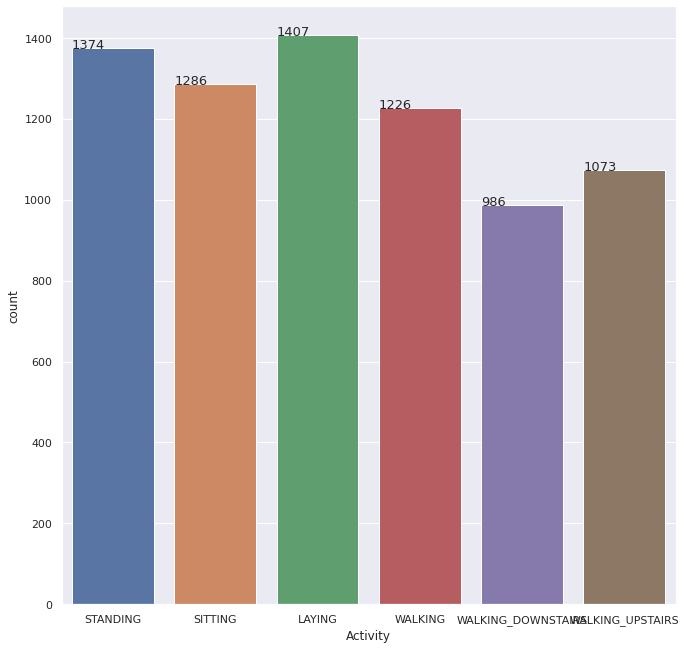

In [ ]:
# Plotting data

sns.set(rc={'figure.figsize':(11,11)})
ax = sns.countplot(x='Activity', data=train_df)
for i in ax.patches:
  ax.text(x=i.get_x(),y=i.get_height(), s=str(i.get_height()),fontsize=13)

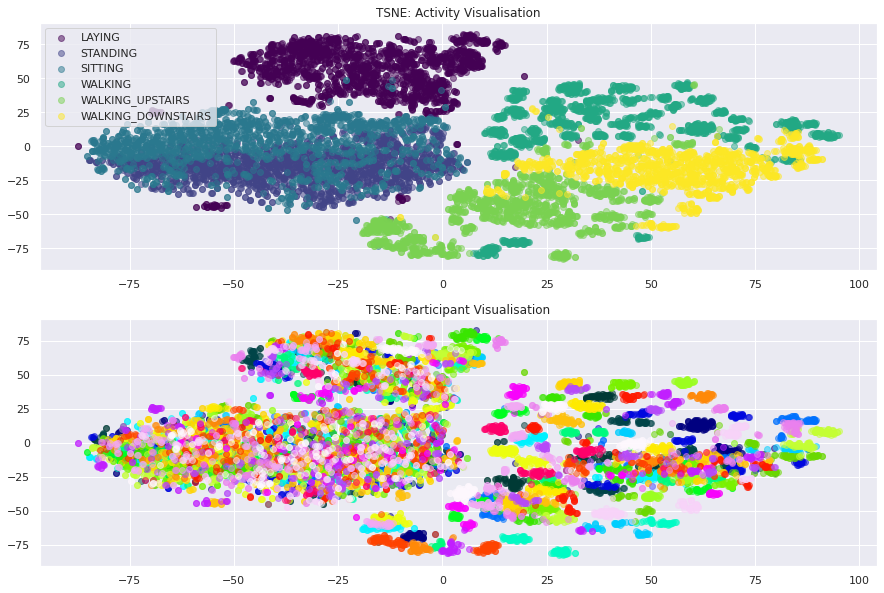

In [ ]:
# Create datasets
tsne_data = both_df.copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Reduce dimensions (speed up)
pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(tsne_data)


# Create subplots
fig, axarr = plt.subplots(2, 1, figsize=(15,10))

### Plot Activities
# Get colors
n = label.unique().shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each activity
for i, group in enumerate(label_counts.index):
    # Mask to separate sets
    mask = (label==group).values
    axarr[0].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
axarr[0].set_title('TSNE: Activity Visualisation')
axarr[0].legend()


### Plot Subjects
# Get colors
n = subject_data.unique().shape[0]
colormap = get_cmap('gist_ncar')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each participant
for i, group in enumerate(subject_data.unique()):
    # Mask to separate sets
    mask = (subject_data==group).values
    axarr[1].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)

axarr[1].set_title('TSNE: Participant Visualisation')
plt.show()

In [ ]:
#splitting into train and test data
enc = LabelEncoder()#label encoding
label_encoded = enc.fit_transform(label)
X_train, X_test, y_train, y_test = train_test_split(tsne_data, label_encoded, random_state=3)

In [ ]:
from sklearn.ensemble import RandomForestClassifier #Supervised
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred, average='weighted'))

0.9355339805825242
0.9360300631885274


In [ ]:
duration_df = (both_df.groupby([label, subject_data])['Data'].count().reset_index().groupby('Activity').agg({'Data':'mean'}) * 1.28).rename(columns={'Data':'Seconds'})
activity_df = pd.DataFrame(data, columns=['Activity', 'Accuracy']).set_index('Activity')
activity_df.join(duration_df)

In [ ]:
from sklearn.tree import DecisionTreeClassifier 
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

from sklearn import metrics 
print("Accuracy:",accuracy_score(y_test, y_pred))
print("Precision:",precision_score(y_test,y_pred,average='weighted'))

Accuracy: 0.8438834951456311
Precision: 0.8448150838508767


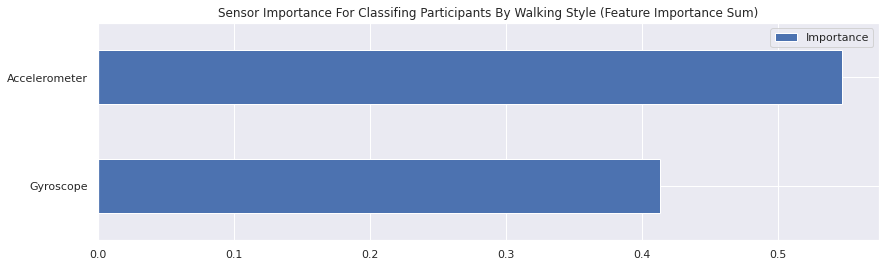

In [ ]:
tsne_data = both_df[label=='WALKING'].copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Split training testing data
enc = LabelEncoder()
label_encoded = enc.fit_transform(subject_data)
X_train, X_test, y_train, y_test = train_test_split(tsne_data, label_encoded, random_state=3)
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = 0)
classifier.fit(X_train, y_train)
features = both_df.drop(['Data', 'subject'], axis=1).columns
importances = classifier.feature_importances_
data = {'Gyroscope':0, 'Accelerometer':0}
for importance, feature in zip(importances, features):
    if 'Gyro' in feature:
        data['Gyroscope'] += importance
    if 'Acc' in feature:
        data['Accelerometer'] += importance
        
# Create dataframe and plot
sensor_df = pd.DataFrame.from_dict(data, orient='index').rename(columns={0:'Importance'})
sensor_df.plot(kind='barh', figsize=(14,4), title='Sensor Importance For Classifing Participants By Walking Style (Feature Importance Sum)')
plt.show()

